In [18]:
from typing import cast

import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [19]:
result_df = pd.DataFrame(columns=['Model', 'RMSE_test', 'RMSE_train', 'MAE_test', 'MAE_train'])

In [20]:
import seaborn as sns
df = sns.load_dataset('diamonds')

train_df, test_df = train_test_split(df, test_size=0.2)

In [21]:
df[["cut", "color", "clarity"]].nunique()

cut        5
color      7
clarity    8
dtype: int64

In [22]:
def evaluate(model, model_name, train_df, test_df, result_df):
    preds_train = model.predict(train_df.drop('price', axis=1))
    preds_test = model.predict(test_df.drop('price', axis=1))
    
    rmse_train = root_mean_squared_error(train_df['price'], preds_train)
    rmse_test = root_mean_squared_error(test_df['price'], preds_test)
    mae_train = mean_absolute_error(train_df['price'], preds_train)
    mae_test = mean_absolute_error(test_df['price'], preds_test)
    
    result_df.loc[len(result_df)] = [model_name, rmse_test, rmse_train, mae_test, mae_train]

    print(f'Train RMSE: {rmse_train}')
    print(f'Train MAE: {mae_train}')
    print(f'Test RMSE: {rmse_test}')
    print(f'Test MAE: {mae_test}')


In [23]:
from sklearn.linear_model import LinearRegression

train_non_cat_df = train_df.select_dtypes(exclude='category')
test_non_cat_df = test_df.select_dtypes(exclude='category')

model_lr = LinearRegression()
model_lr.fit(train_non_cat_df.drop('price', axis=1), train_non_cat_df['price'])

evaluate(model_lr, 'Regression non-categorical', train_non_cat_df, test_non_cat_df, result_df)


Train RMSE: 1496.7760457375086
Train MAE: 891.8081818769641
Test RMSE: 1497.3906985438398
Test MAE: 888.480863390114


2. Построить решение методом бустинга (подобрать оптимальные параметры сложности). Сравнить с линейной регрессией.

In [26]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [5, 6, 7],
    'n_estimators': [50, 100, 200, 500, 600],
    'learning_rate': [0.01]
}

model = GradientBoostingRegressor(random_state=42)

grid = GridSearchCV(
    model,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid.fit(train_non_cat_df.drop('price', axis=1), train_non_cat_df['price'])

,estimator,GradientBoost...ndom_state=42)
,param_grid,"{'learning_rate': [0.01], 'max_depth': [5, 6, ...], 'n_estimators': [50, 100, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'squared_error'


In [27]:
model_gb = GradientBoostingRegressor(random_state=42, **grid.best_params_)
model_gb.fit(train_non_cat_df.drop('price', axis=1), train_non_cat_df['price'])

evaluate(model_gb, 'Boosting non-categorical', train_non_cat_df, test_non_cat_df, result_df)

Train RMSE: 1257.1949175862399
Train MAE: 726.5183690712274
Test RMSE: 1335.2557515423898
Test MAE: 762.442656172046


3. Применить one hot и target encoding для категориальных признаков (взять данные, где такие признаки есть). Сравнить точность.

In [28]:
train_df_te, test_df_te = train_df.copy(), test_df.copy()

cat_cols = df.select_dtypes(include='category').columns.to_list()

for col in cat_cols:
    mapping = train_df.groupby(col, observed=False)["price"].mean()
    train_df_te[col] = train_df_te[col].map(mapping)
    test_df_te[col] = test_df_te[col].map(mapping)

model_te_reg = LinearRegression()
model_te_reg.fit(train_df_te.drop('price', axis=1), train_df_te['price'])
evaluate(model_te_reg, 'Regression target encoding', train_df_te, test_df_te, result_df)


model_te = GradientBoostingRegressor(random_state=42, **grid.best_params_)
model_te.fit(train_df_te.drop('price', axis=1), train_df_te['price'])
evaluate(model_te, 'Boosting target encoding', train_df_te, test_df_te, result_df)


Train RMSE: 1286.2312637487619
Train MAE: 809.4777758226816
Test RMSE: 1297.2572603260357
Test MAE: 806.4147360376578
Train RMSE: 491.64889651417457
Train MAE: 267.5671236942563
Test RMSE: 549.984821519517
Test MAE: 286.6104885626161


In [29]:
train_df_te, test_df_te = train_df.copy(), test_df.copy()

train_ohe_df = pd.get_dummies(train_df, columns=cat_cols, drop_first=True)
test_ohe_df  = pd.get_dummies(test_df,  columns=cat_cols, drop_first=True)

model_one_hot_reg = LinearRegression()
model_one_hot_reg.fit(train_ohe_df.drop('price', axis=1), train_ohe_df['price'])
evaluate(model_one_hot_reg, 'Regression one-hot encoding', train_ohe_df, test_ohe_df, result_df)

model_one_hot = GradientBoostingRegressor(random_state=42, **grid.best_params_)
model_one_hot.fit(train_ohe_df.drop('price', axis=1), train_ohe_df['price'])

evaluate(model_one_hot, 'Boosting one-hot encoding', train_ohe_df, test_ohe_df, result_df)


Train RMSE: 1128.5697163572002
Train MAE: 742.2563516523815
Test RMSE: 1135.211644519064
Test MAE: 737.1513665933293
Train RMSE: 607.0677533319799
Train MAE: 314.5560214559953
Test RMSE: 645.980258982291
Test MAE: 330.93937509496504


In [33]:
result_df.head(6)

,Model,RMSE_test,RMSE_train,MAE_test,MAE_train
0,Regression non-categorical,1497.390699,1496.776046,888.480863,891.808182
1,Boosting non-categorical,1335.255752,1257.194918,762.442656,726.518369
2,Regression target encoding,1297.257260,1286.231264,806.414736,809.477776
3,Boosting target encoding,549.984822,491.648897,286.610489,267.567124
4,Regression one-hot encoding,1135.211645,1128.569716,737.151367,742.256352
5,Boosting one-hot encoding,645.980259,607.067753,330.939375,314.556021


4. Визуализировать объекты (не обязательно для той же таблицы) в пространстве главных компонент.

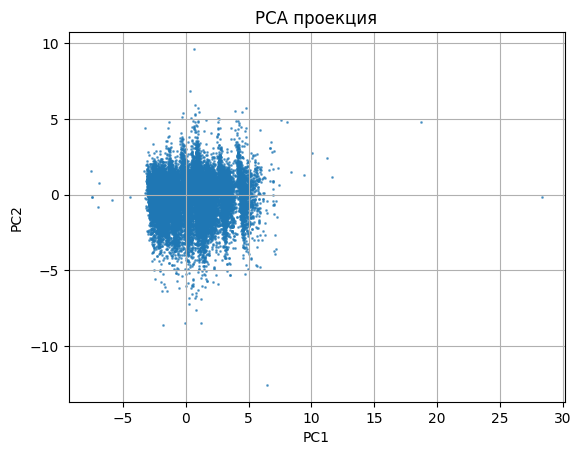

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_df_te.select_dtypes(exclude='category').drop(["price"], axis=1))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.6, s=1)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA проекция")
plt.grid(True)
plt.show()